<div style="text-align: right">   </div>


Introduction to Deep Learning (2024) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Sequence processing using RNNs** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Preparation

## Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell, Input
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose
from keras import backend as K
import pandas as pd
import seaborn as sns
print(tf.config.list_physical_devices('GPU'))

2024-12-08 17:02:55.127309: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-08 17:03:00.341791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733673781.967297 3311088 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733673782.520104 3311088 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 17:03:07.307270: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


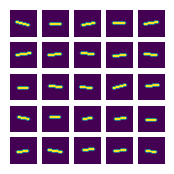

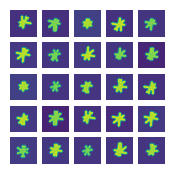

In [2]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates (num x 2 array of btwn 12 & 16)
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images 
        # cv2.line(image, start_point, end_point, color, thickness, linetype) 
        # Use (y,x) instead of (x,y) for horizontal line
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='*'))

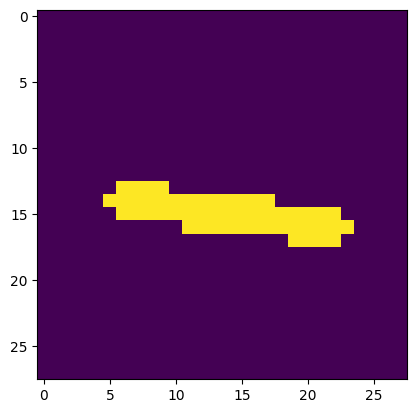

In [3]:
import numpy as np
import cv2
# Creating a black screen image using numpy.zeros function
Img = np.zeros((28, 28), dtype='uint8')
start_point = (6, 14) 
end_point = (22, 16)
image = cv2.line(Img, start_point, end_point, color = (255, 250, 255), thickness = 2)
plt.imshow(image)
plt.show()

In [4]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)] # Get indices of labels that match each labels in a 10xn array
    num_data = [MNIST_data[inds] for inds in num_indices] # Get the number data
    image_mapping = dict(zip(unique_characters[:10], num_data)) #unique_char = '0123456789+- ', [:10] is 0 to 9 (string form)
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                # data is created as i +/- j e.g [0]: 0+0, [1]:0-0, [2]:0+1, [3]:0-1
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char] 
                    index = np.random.randint(0, len(image_set), 1) #random char image from set
                    query_image.append(image_set[index].squeeze()) #squeeze remove useless dim e.g (1.3,3) to (3,3)

                result = eval(query_string) # python function to evaluate string as number as int/float
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


## Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #9185

X_text: "45-92" = y_text: "-47"


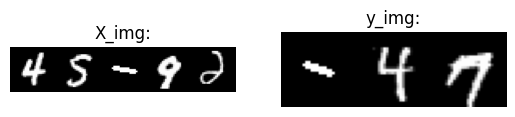

Query #18579

X_text: "92-89" = y_text: "3  "


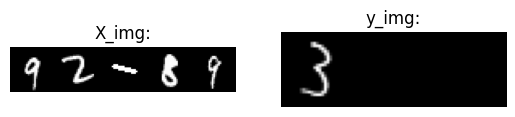

Query #16742

X_text: "83+71" = y_text: "154"


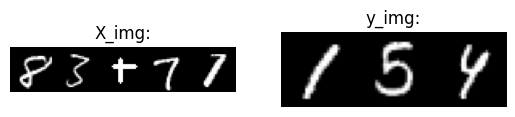

Query #17449

X_text: "87-24" = y_text: "63 "


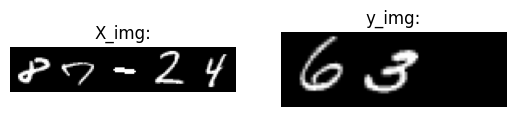

Query #7745

X_text: "38-72" = y_text: "-34"


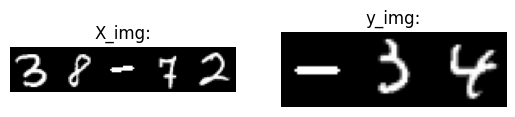

Query #13606

X_text: "68+3 " = y_text: "71 "


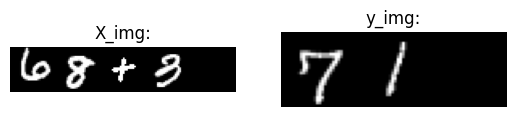

Query #9509

X_text: "47-54" = y_text: "-7 "


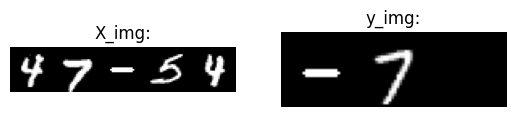

Query #3035

X_text: "15-17" = y_text: "-2 "


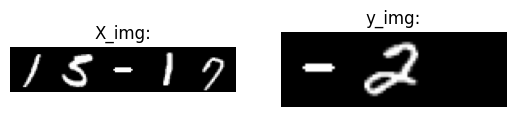

Query #579

X_text: "2-89 " = y_text: "-87"


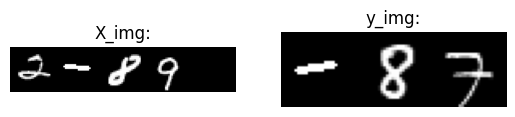

Query #13682

X_text: "68+41" = y_text: "109"


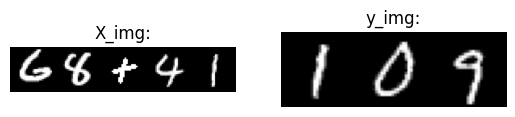

In [5]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data() #60000 data
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 20000, 1)[0]) #randomly select

Query #1

X_text: "0-0  " = y_text: "0  "


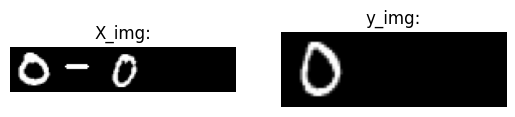

In [6]:
display_sample(1)


## Helper functions

The functions below will help with input/output of the data.

In [7]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3): #encode string to numeric array: 0-9 as 0-9, -,+,' ' as 10,11,12| based on unique_characters = '0123456789+- ' 
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


In [8]:
print(X_text_onehot[2])
decode_labels(X_text_onehot[2])

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


'0+1  '

# Models

---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [11]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [ ]:
X_text

In [75]:
## Your code (look at the assignment description for your tasks for text-to-text model):
## Your first task is to fit the text2text model using X_text and y_text
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-4, verbose=1)

his_t2t = []
t2t_model_l = []
split = [0.2,0.5,0.75,0.9]
data_split_tt = []
for i in range(len(split)):
    train_x, test_x, train_y, test_y = train_test_split(X_text_onehot, y_text_onehot, test_size=split[i], random_state=42)
    data_split_tt.append([train_x, test_x, train_y, test_y])
    K.clear_session()
    t2t_model = build_text2text_model()
    his_t2t.append(t2t_model.fit(train_x, train_y,
                                 epochs = 100,
                                 validation_split=0.1,
                                 batch_size = 32,
                                 callbacks = [reduce_lr,early_stopping],
                                 verbose = 1))
    t2t_model_l.append(t2t_model)



/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3358 - loss: 2.0334 - val_accuracy: 0.4702 - val_loss: 1.5027 - learning_rate: 0.0010
Epoch 2/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4767 - loss: 1.4498 - val_accuracy: 0.5327 - val_loss: 1.3032 - learning_rate: 0.0010
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5451 - loss: 1.2462 - val_accuracy: 0.5996 - val_loss: 1.1331 - learning_rate: 0.0010
Epoch 4/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5797 - loss: 1.1360 - val_accuracy: 0.5842 - val_loss: 1.1040 - learning_rate: 0.0010
Epoch 5/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6015 - loss: 1.0786 - val_accuracy: 0.6212 - val_loss: 1.0059 - learning_rate: 0.0010
Epoch 6/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6225 - loss: 1.0170 - val_accuracy: 0.5879 - val_loss: 1.0756 - learning_rate: 0.0010
Epoch 7/100
447/450 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6284 - loss: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3094 - loss: 2.1118 - val_accuracy: 0.4103 - val_loss: 1.6658 - learning_rate: 0.0010
Epoch 2/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4372 - loss: 1.5833 - val_accuracy: 0.4983 - val_loss: 1.3966 - learning_rate: 0.0010
Epoch 3/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5035 - loss: 1.3733 - val_accuracy: 0.5457 - val_loss: 1.2646 - learning_rate: 0.0010
Epoch 4/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5417 - loss: 1.2562 - val_accuracy: 0.5850 - val_loss: 1.1604 - learning_rate: 0.0010
Epoch 5/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5712 - loss: 1.1728 - val_accuracy: 0.5917 - val_loss: 1.1309 - learning_rate: 0.0010
Epoch 6/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5804 - loss: 1.1345 - val_accuracy: 0.5777 - val_loss: 1.1382 - learning_rate: 0.0010
Epoch 7/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6003 - loss: 1.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2642 - loss: 2.2707 - val_accuracy: 0.4027 - val_loss: 1.8043 - learning_rate: 0.0010
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3905 - loss: 1.7898 - val_accuracy: 0.4240 - val_loss: 1.7000 - learning_rate: 0.0010
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4177 - loss: 1.6247 - val_accuracy: 0.4373 - val_loss: 1.6005 - learning_rate: 0.0010
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4589 - loss: 1.4934 - val_accuracy: 0.5020 - val_loss: 1.4051 - learning_rate: 0.0010
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5027 - loss: 1.3803 - val_accuracy: 0.5227 - val_loss: 1.3404 - learning_rate: 0.0010
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5234 - loss: 1.3224 - val_accuracy: 0.5127 - val_loss: 1.3427 - learning_rate: 0.0010
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5357 - loss: 1.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2042 - loss: 2.4028 - val_accuracy: 0.2950 - val_loss: 2.1216 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3554 - loss: 1.9970 - val_accuracy: 0.3850 - val_loss: 1.8679 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3943 - loss: 1.8292 - val_accuracy: 0.4033 - val_loss: 1.7684 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4000 - loss: 1.7532 - val_accuracy: 0.4017 - val_loss: 1.7605 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3986 - loss: 1.7243 - val_accuracy: 0.4200 - val_loss: 1.6727 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4137 - loss: 1.6485 - val_accuracy: 0.4417 - val_loss: 1.6141 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4268 - loss: 1.5944 - val_acc

125/125 - 0s - 2ms/step - accuracy: 0.9991 - loss: 0.0058
313/313 - 1s - 3ms/step - accuracy: 0.9945 - loss: 0.0193
469/469 - 1s - 3ms/step - accuracy: 0.9000 - loss: 0.3034
563/563 - 1s - 2ms/step - accuracy: 0.6379 - loss: 1.0236


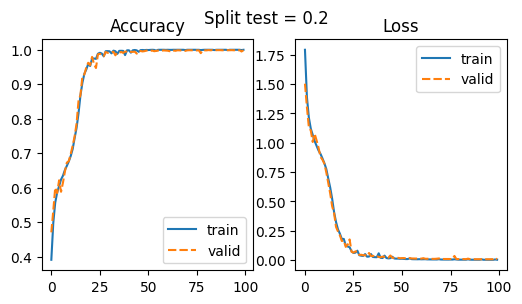

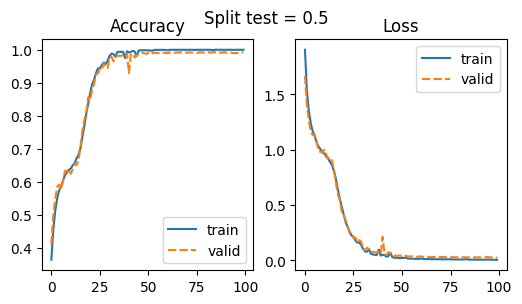

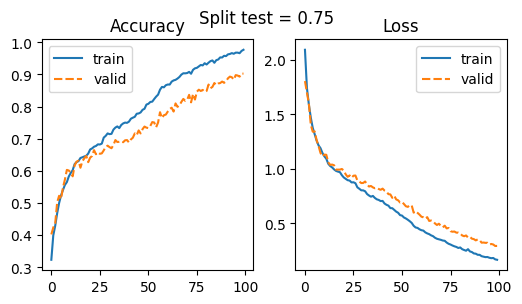

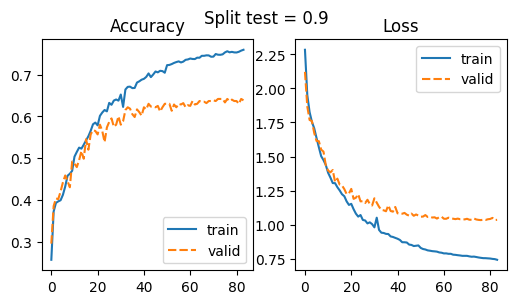

In [76]:
n1 = len(split)
for i in range(n1):
    fig, axs = plt.subplots(ncols=2, figsize=(6,3))
    acc_df = pd.DataFrame()
    loss_df = pd.DataFrame()
    acc_df['train'] = his_t2t[i].history['accuracy']
    acc_df['valid'] = his_t2t[i].history['val_accuracy']
    loss_df['train'] = his_t2t[i].history['loss']
    loss_df['valid'] = his_t2t[i].history['val_loss']
    sns.lineplot(acc_df,ax=axs[0]).set_title("Accuracy")
    sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
    plt.suptitle(f"Split test = {split[i]}")
    t2t_model_l[i].evaluate(data_split_tt[i][1],  data_split_tt[i][3], verbose=2)

In [144]:
def operation_err(output1, pred1, input1):
    query1 = [decode_labels(q1) for q1 in input1]
    answer1 = [decode_labels(a1) for a1 in output1]
    pred1 = [decode_labels(p1) for p1 in pred1]
    op_dic = {'+':[0,0],'-':[0,0]}
    for i in range(len(pred1)):
        if pred1[i] == answer1[i]:
            if '-' in query1[i]:
                op_dic['-'][0]+=1
            else:
                op_dic['+'][0]+=1
        else:
            if '-' in query1[i]:
                op_dic['-'][1]+=1
            else:
                op_dic['+'][1]+=1
    return op_dic          


def acc_inout(output1, pred1, plot_scat = True, plot_correct = False):
    answer1 = [decode_labels(a1) for a1 in output1]
    pred1 = [decode_labels(p1) for p1 in pred1]
    # print(answer1)
    # print(pred1)
    err_lis = []
    wrong_pred =[]
    wrong_ans = []
    for j in range(max_answer_length):
        err_lis.append({x:{x:0 for x in unique_characters} for x in unique_characters})
    for i in range(len(pred1)):
        if pred1[i] == answer1[i]:
            pass
        else:
            for k in range(max_answer_length):
                err_lis[k][answer1[i][k]][pred1[i][k]] += 1
            wrong_pred.append(pred1[i])
            wrong_ans.append(answer1[i])
    title = "Scatter Plot of ALL predictions against answers"
    if not plot_correct:
        pred1 = wrong_pred
        answer1 = wrong_ans
        title = "Scatter Plot of WRONG predictions against answers"
    
    if plot_scat:
        x = []
        y = []
        non_num_err = []
        for m in range(len(pred1)):
            try:
                y.append(int(pred1[m]))
                x.append(int(answer1[m]))
            except:
                non_num_err.append((answer1[m],pred1[m]))
                continue
        sns.scatterplot(x = x,y = y)
        m1 = min(x)
        m2 = max(x)
        plt.plot([m1,m2],[m1,m2], color='red', linestyle='--',alpha=0.5)
        plt.xlabel("Answer Values")
        plt.ylabel("Predict Values")
        plt.title(title)
        plt.show()
        print(non_num_err)
        print(f"Number of non-numeric prediction: {len(non_num_err)}")
        mae = np.abs(np.array(x)-np.array(y))
        print(f"Max Abs Err: {max(mae)}")
        print(f"Med AE: {np.median(mae):.3f}")
        print(f"MAE: {np.mean(mae):.3f}")
    return err_lis
            
            
    

  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


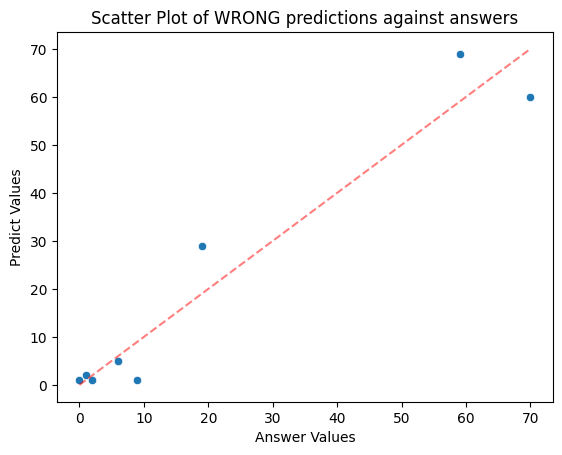

[('-1 ', '-  ')]
Number of non-numeric prediction: 1
Max Abs Err: 10
Med AE: 1.000
MAE: 4.400
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step


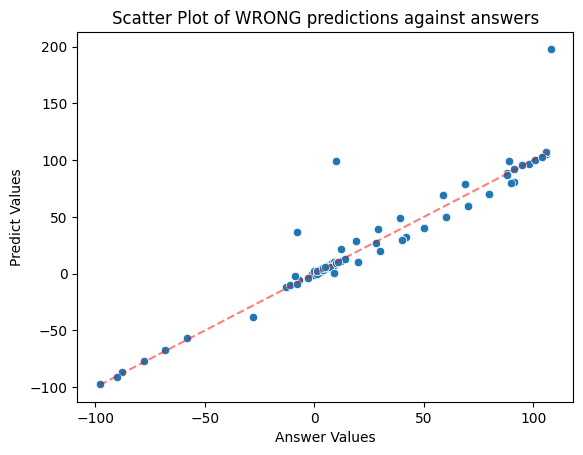

[('-2 ', '-  '), ('0  ', '-  '), ('-1 ', '-  ')]
Number of non-numeric prediction: 3
Max Abs Err: 90
Med AE: 1.000
MAE: 6.320
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step


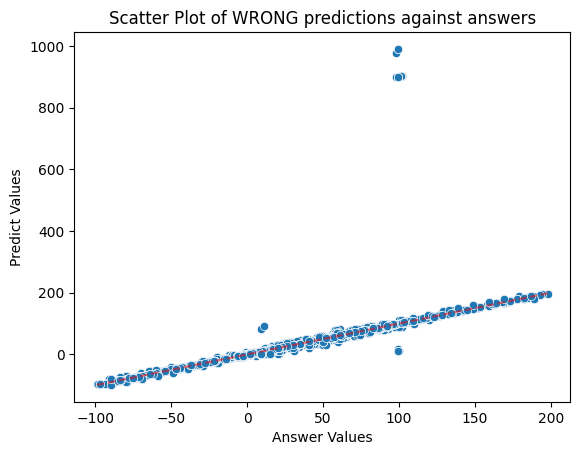

[('-1 ', '-  '), ('-1 ', '-  '), ('-1 ', '-  '), ('-1 ', '-  '), ('0  ', '-  '), ('0  ', '-  '), ('2  ', '-  '), ('-1 ', '-  '), ('0  ', '-  '), ('0  ', '-  '), ('-1 ', '-  '), ('-1 ', '-  '), ('0  ', '-  '), ('-1 ', '-  '), ('0  ', '-  '), ('-1 ', '-  '), ('-1 ', '-  '), ('0  ', '-  '), ('-1 ', '-  ')]
Number of non-numeric prediction: 19
Max Abs Err: 891
Med AE: 1.000
MAE: 6.539
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step


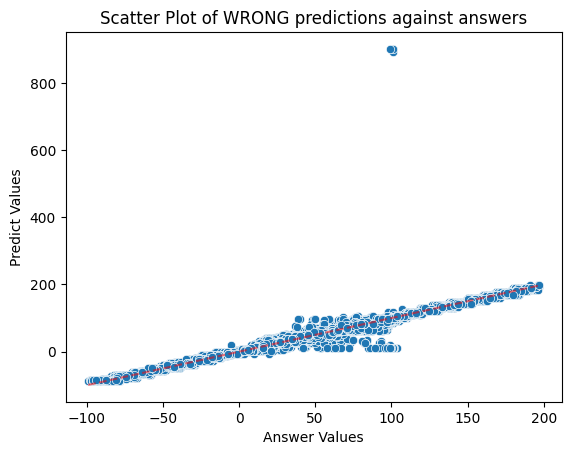

[('0  ', '-  '), ('0  ', '-  '), ('-2 ', '-  '), ('-2 ', '-  '), ('-1 ', '-  '), ('1  ', '-  '), ('0  ', '-  '), ('1  ', '-  '), ('-4 ', '-  '), ('0  ', '-  '), ('1  ', '-  '), ('21 ', '-  '), ('0  ', '-  '), ('0  ', '-  '), ('-2 ', '-  '), ('-1 ', '-  '), ('-1 ', '-  '), ('3  ', '-  '), ('-1 ', '-  '), ('2  ', '-  '), ('-1 ', '-  '), ('1  ', '-  '), ('1  ', '-  '), ('0  ', '-  '), ('-1 ', '-  '), ('0  ', '-  '), ('4  ', '-  '), ('3  ', '-  '), ('-1 ', '-  '), ('16 ', '-  '), ('0  ', '-  '), ('1  ', '-  '), ('15 ', '-  '), ('1  ', '-  '), ('-1 ', '-  '), ('1  ', '-  '), ('-1 ', '-  '), ('1  ', '-  '), ('-2 ', '-  '), ('10 ', '-  '), ('4  ', '-  '), ('-1 ', '-  '), ('-1 ', '-  '), ('-1 ', '-  '), ('1  ', '-  '), ('2  ', '-  '), ('-2 ', '-  '), ('2  ', '-  '), ('0  ', '-  '), ('0  ', '-  '), ('-2 ', '-  '), ('1  ', '-  '), ('-4 ', '-  '), ('-1 ', '-  '), ('-2 ', '-  '), ('1  ', '-  '), ('-1 ', '-  '), ('0  ', '-  '), ('1  ', '-  '), ('2  ', '-  '), ('4  ', '-  '), ('1  ', '-  '), ('1  ',

In [145]:
ope_lis = []
err_lis = []
for i in range(n1):
    q1 = data_split_tt[i][1]
    a1 = data_split_tt[i][3]
    p1 = t2t_model_l[i].predict(q1)
    x = operation_err(a1,p1,q1)
    y = acc_inout(a1,p1)
    ope_lis.append(x)
    err_lis.append(y)

        

[{'+': [1988, 6], '-': [2001, 5]}, {'+': [4975, 66], '-': [4869, 90]}, {'+': [5875, 1636], '-': [5048, 2441]}, {'+': [1047, 7945], '-': [875, 8133]}]
Accuracy of sequence 1: 0.99750
Accuracy of sequence 2: 0.99975
Accuracy of sequence 3: 1.00000
Evaluated accuracy: 0.99908
Total Sequence Accuracy: 0.99725


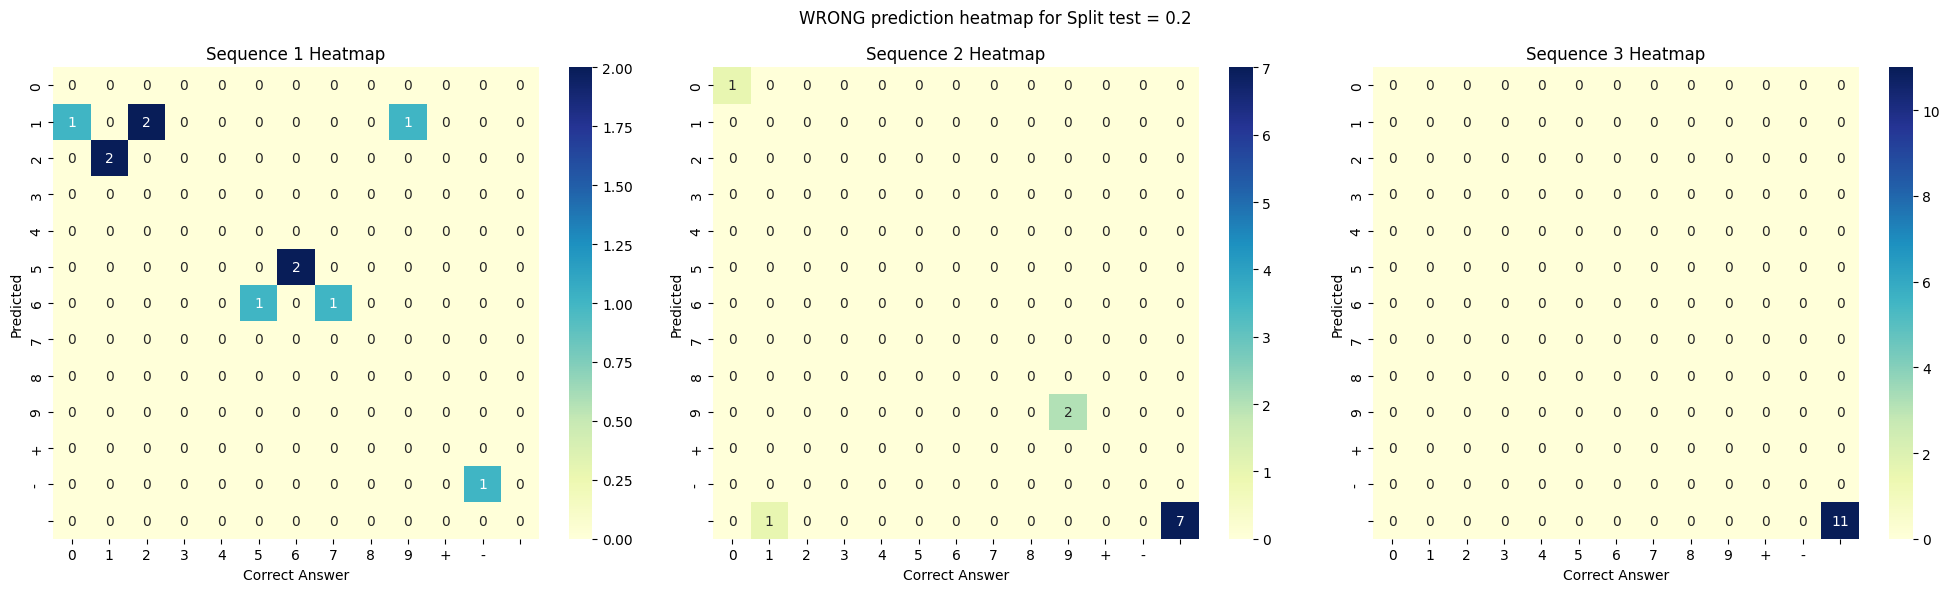

Accuracy of sequence 1: 0.98800
Accuracy of sequence 2: 0.99730
Accuracy of sequence 3: 0.99830
Evaluated accuracy: 0.99453
Total Sequence Accuracy: 0.98440


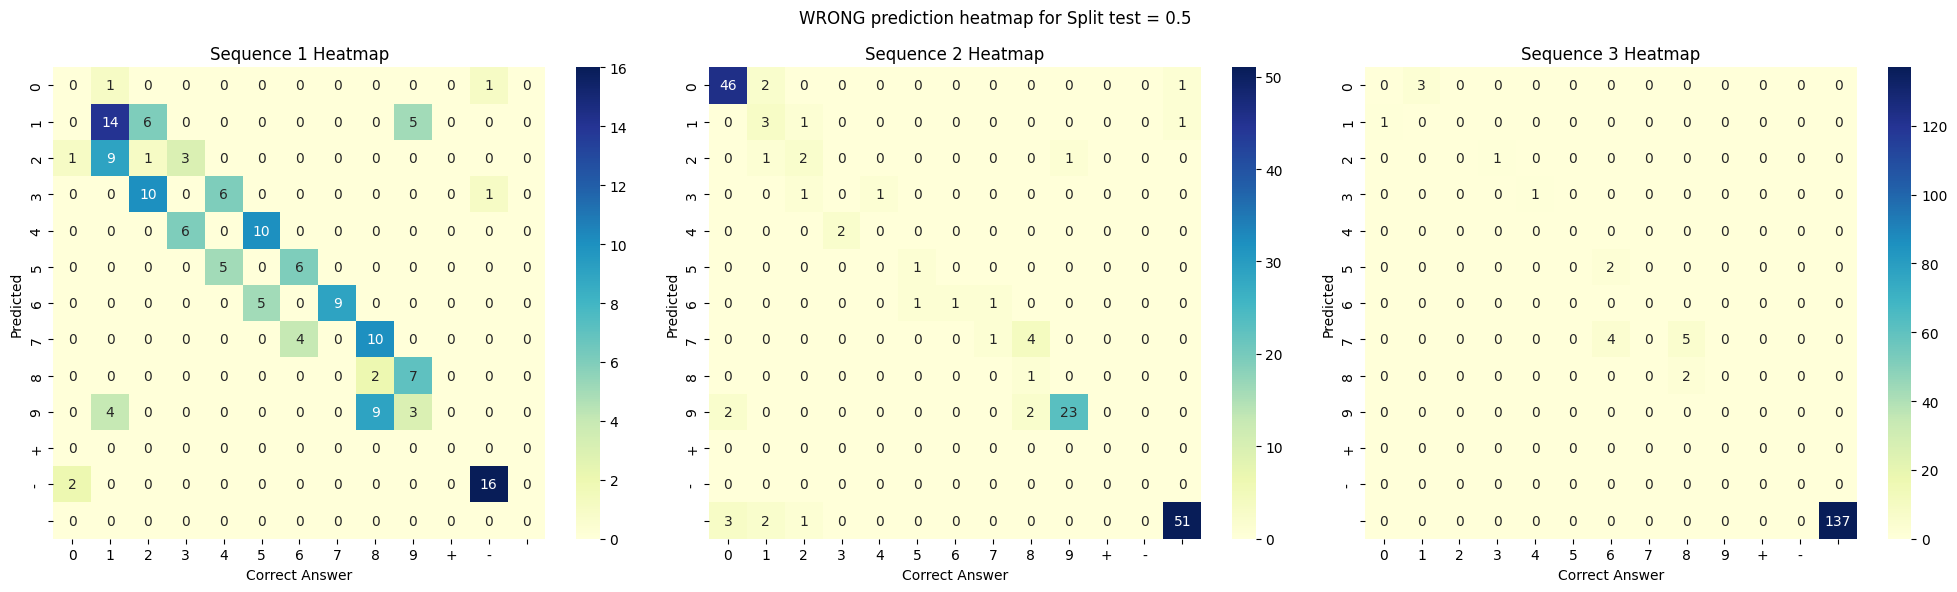

Accuracy of sequence 1: 0.91860
Accuracy of sequence 2: 0.83693
Accuracy of sequence 3: 0.94433
Evaluated accuracy: 0.89996
Total Sequence Accuracy: 0.72820


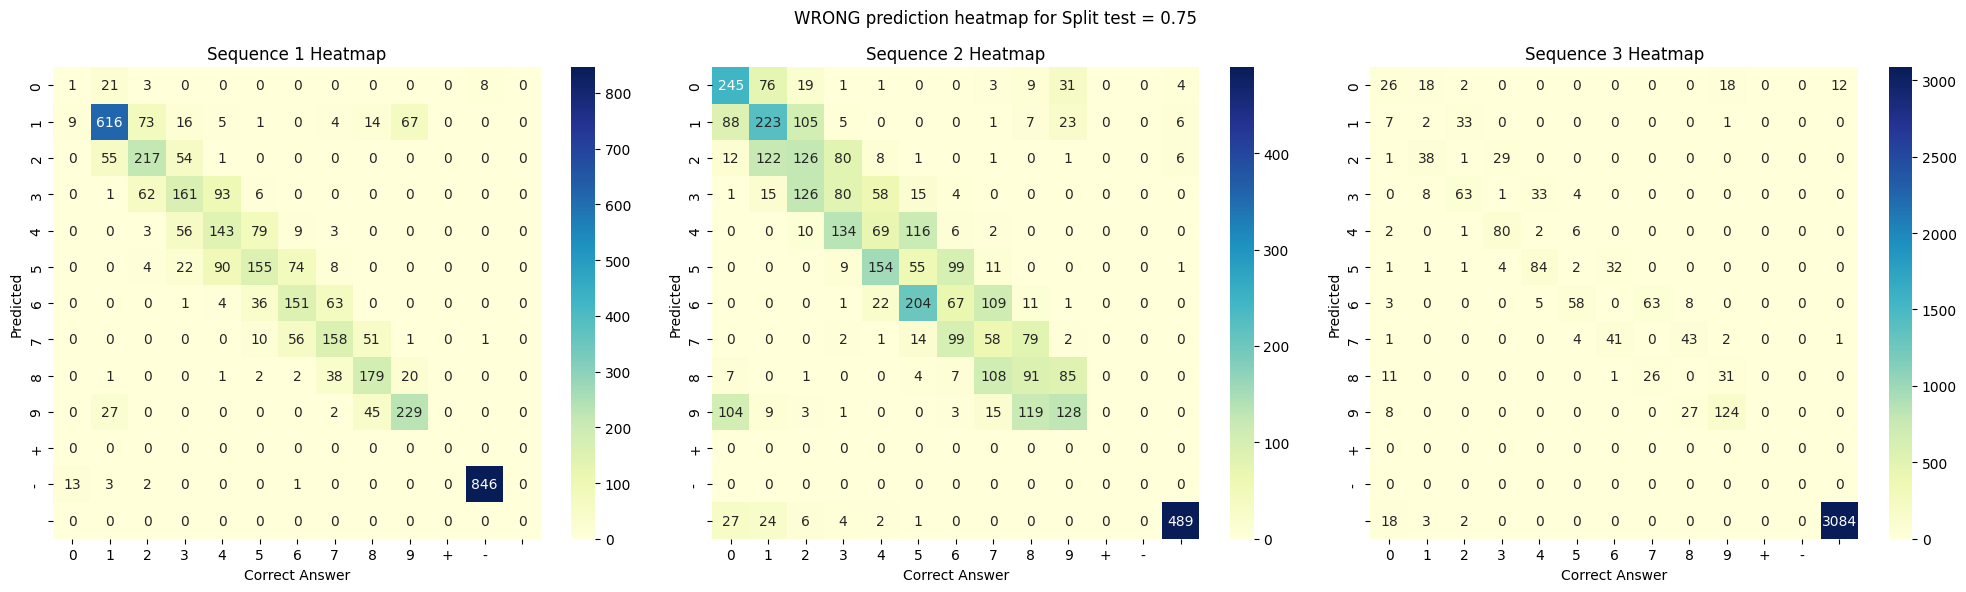

Accuracy of sequence 1: 0.79717
Accuracy of sequence 2: 0.50539
Accuracy of sequence 3: 0.61106
Evaluated accuracy: 0.63787
Total Sequence Accuracy: 0.10678


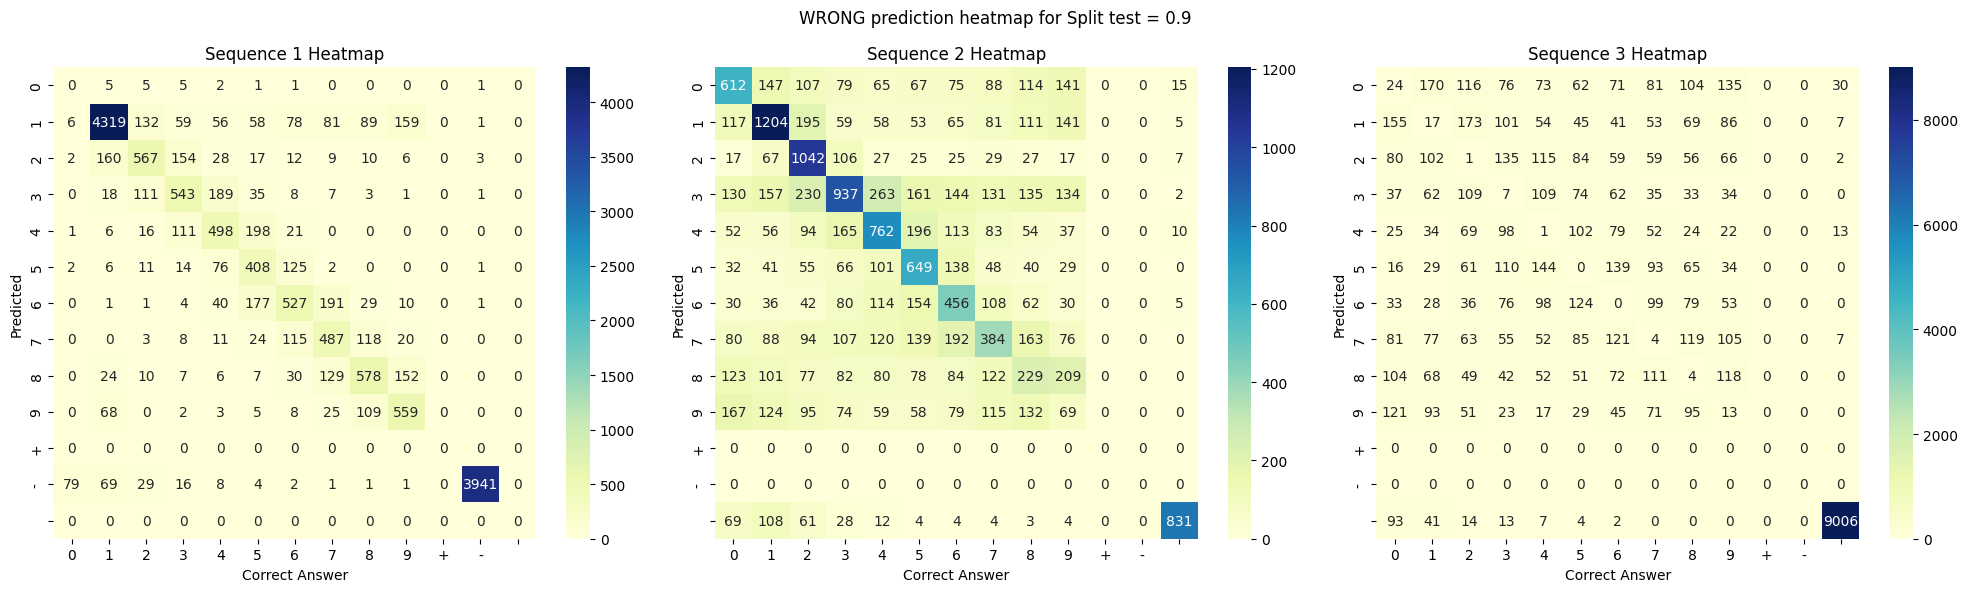

In [146]:
print(ope_lis)
for i in range(len(err_lis)):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))  
    eval_accu = []
    for posi in range(len(err_lis[i])):
        df = pd.DataFrame(err_lis[i][posi])
        sns.heatmap(df, annot=True, fmt="d", cmap="YlGnBu", ax=axes[posi])
        axes[posi].set_title(f"Sequence {posi+1} Heatmap")
        axes[posi].set_xlabel("Correct Answer")
        axes[posi].set_ylabel("Predicted")
        diagsum = np.trace(df)
        wrong_per = df.to_numpy().sum() - diagsum
        seq_accu = 1-wrong_per/len(data_split_tt[i][1])
        print(f"Accuracy of sequence {posi+1}: {seq_accu:.5f}")
        eval_accu.append(seq_accu)
    print(f"Evaluated accuracy: {sum(eval_accu)/len(eval_accu):.5f}")
    total_accu = 1-df.to_numpy().sum()/len(data_split_tt[i][1])
    print(f"Total Sequence Accuracy: {total_accu:.5f}")
    plt.suptitle(f"WRONG prediction heatmap for Split test = {split[i]}")
    plt.tight_layout()
    plt.show()



In [83]:
operation_lis = []
err_lis = []
for i in range(n1):
    pred = t2t_model_l[i].predict(data_split[i][1][:2])
    # print(np.argmax(pred,axis=2))
    # print(np.argmax(pred,axis=2).shape)
    # one_hot_predictions = np.zeros_like(pred)
    # np.put_along_axis(one_hot_predictions, np.argmax(pred, axis=-1)[..., np.newaxis], 1, axis=-1)
    # print(one_hot_predictions)  # Output: (10, 5, 13)
    print("-"*24)
    print(f"Split test = {split[i]}")
    print("-"*24)
    for j in range(len(pred)):
        print(f"Q{j+1}: {decode_labels(data_split[i][1][j])}")
        print(f"Pred: {decode_labels(pred[j])}")
        print(f"Ans: {decode_labels(data_split[i][3][j])}")
        print("#"*24)

    



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
------------------------
Split test = 0.2
------------------------
Q1: 53+25
Pred: 78 
Ans: 78 
########################
Q2: 10-20
Pred: -10
Ans: -10
########################
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
------------------------
Split test = 0.5
------------------------
Q1: 53+25
Pred: 78 
Ans: 78 
########################
Q2: 10-20
Pred: -10
Ans: -10
########################
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
------------------------
Split test = 0.75
------------------------
Q1: 53+25
Pred: 78 
Ans: 78 
########################
Q2: 10-20
Pred: -10
Ans: -10
########################
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
------------------------
Split test = 0.9
------------------------
Q1: 53+25
Pred: 78 
Ans: 78 
########################
Q2: 10-20
Pred: -9 
Ans: -10
########################



---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [ ]:
## Your code
def build_image2text_model():

    # We start by initializing a sequential model
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape=(5, 28, 28)))
    model.add(tf.keras.layers.Reshape(target_shape=(5,28,28,1)))
    # model.add(tf.keras.layers.Rescaling(1./255))
    
    #encode
    model.add(ConvLSTM2D(16,(3,3),
                         activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l2(0.05),
                         return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(256,kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(tf.keras.layers.Dropout(0.2))
    #Decode
    model.add(RepeatVector(max_answer_length))
    model.add(LSTM(256, return_sequences= True))
    model.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    model.compile(loss='categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
                  metrics=['accuracy'])
    model.summary()

    return model




In [ ]:
t2i_model = build_image2text_model()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_4 (Reshape)             │ (None, 5, 28, 28, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, 5, 28, 28, 4)   │           736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 28, 28, 4)   │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 5, 14, 14, 4)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 14, 14, 4)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 5, 784)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │       217,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 3, 13)          │           845 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,965 (984.24 KB)

 Trainable params: 251,957 (984.21 KB)

 Non-trainable params: 8 (32.00 B)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

his_i2t = []
i2t_model_l = []
split = [0.5]
data_split = []
for i in range(len(split)):
    train_x, test_x, train_y, test_y = train_test_split(X_img, y_text_onehot, test_size=split[i], random_state=1245)
    data_split.append([train_x, test_x, train_y, test_y])
    K.clear_session()
    i2t_model = build_image2text_model()
    his_i2t.append(i2t_model.fit(train_x, train_y,
                                 epochs = 50,
                                 validation_split=0.1,
                                 batch_size = 32,
                                 verbose = 1,
                                 callbacks = [early_stopping,reduce_lr]))
    i2t_model_l.append(i2t_model)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 5, 28, 28, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 26, 26, 16)  │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 26, 26, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 5, 13, 13, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 13, 13, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 2704)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │     3,032,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,570,637 (13.62 MB)

 Trainable params: 3,570,605 (13.62 MB)

 Non-trainable params: 32 (128.00 B)

Epoch 1/50


E0000 00:00:1733493179.388307 1061833 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'StatefulPartitionedCall/sequential_1/conv_lstm2d_1/while/StatefulPartitionedCall/sequential_1/conv_lstm2d_1/zeros_1_switch/_135-0-TransposeNHWCToNCHW-LayoutOptimizer' -> 'StatefulPartitionedCall/sequential_1/conv_lstm2d_1/while/StatefulPartitionedCall/sequential_1/conv_lstm2d_1/zeros_1_switch/_135', 'StatefulPartitionedCall/sequential_1/conv_lstm2d_1/while/body/_55/sequential_1/conv_lstm2d_1/while/conv_lstm_cell_1/Sigmoid_1' -> 'StatefulPartitionedCall/sequential_1/conv_lstm2d_1/while/body/_55/sequential_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul', 'StatefulPartitionedCall/sequential_1/conv_lstm2d_1/while/body/_55/sequential_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul_1' -> 'StatefulPartitionedCall/sequential_1/conv_lstm2d_1/while/body/_55/sequential_1/conv_lstm2d_1/while/conv_lstm_cell_1/add_7', 'StatefulPartitione

282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.3191 - loss: 4.6367 - val_accuracy: 0.3100 - val_loss: 2.2035 - learning_rate: 0.0010
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3869 - loss: 1.9573 - val_accuracy: 0.3983 - val_loss: 1.9367 - learning_rate: 0.0010
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.3963 - loss: 1.9005 - val_accuracy: 0.4027 - val_loss: 1.8493 - learning_rate: 0.0010
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.4044 - loss: 1.8852 - val_accuracy: 0.4147 - val_loss: 1.8192 - learning_rate: 0.0010
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.4108 - loss: 1.8279 - val_accuracy: 0.4337 - val_loss: 1.7665 - learning_rate: 0.0010
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.4192 - loss: 1.8184 - val_accuracy: 0.4243 - val_loss: 1.7709 - learning_rate: 0.0010
Epoch 7/50
280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4323 - loss: 1.7746
Epoch 

313/313 - 2s - 8ms/step - accuracy: 0.5659 - loss: 1.3372


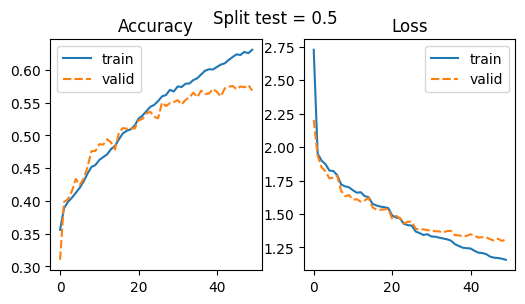

In [32]:
n1 = len(split)
for i in range(n1):
    fig, axs = plt.subplots(ncols=2, figsize=(6,3))
    acc_df = pd.DataFrame()
    loss_df = pd.DataFrame()
    acc_df['train'] = his_i2t[i].history['accuracy']
    acc_df['valid'] = his_i2t[i].history['val_accuracy']
    loss_df['train'] = his_i2t[i].history['loss']
    loss_df['valid'] = his_i2t[i].history['val_loss']
    sns.lineplot(acc_df,ax=axs[0]).set_title("Accuracy")
    sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
    plt.suptitle(f"Split test = {split[i]}")
    i2t_model_l[i].evaluate(data_split[i][1],  data_split[i][3], verbose=2)

### Model 2.2

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [64]:
def build_text2image_model():
    model = tf.keras.Sequential()
    #Encode
    model.add(LSTM(256, input_shape=(None, len(unique_characters))))
    #Decode
    model.add(RepeatVector(max_answer_length))
    model.add(LSTM(256, return_sequences=True))
    # model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(7 * 7 * 128, activation='sigmoid'))) #sigmooid
    model.add(Reshape((3, 7, 7, 128)))
    model.add(TimeDistributed(Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')))   
    model.add(TimeDistributed(Conv2D(filters=1, kernel_size=(3,3), padding='same',activation='sigmoid')))

    model.compile(loss='mse', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=['mse'])
    model.summary()

    return model
build_text2image_model()

class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr, reset_epoch=[10], reset_lr = 1e-3, monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6,cycle=20):
        super().__init__()
        self.initial_lr = initial_lr
        self.reset_epoch = reset_epoch
        self.reset_lr = reset_lr
        self.monitor = monitor
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.best_loss = float('inf')
        self.wait = 0
        self.cycle = cycle
        self.lr_history = []

    def on_epoch_begin(self, epoch, logs=None):
        # print(f"Epoch {epoch+1}: Learning rate = {self.model.optimizer.learning_rate.numpy():.1e}")
        if epoch in self.reset_epoch or (epoch%self.cycle == 0 and epoch >0):
            print(f"Resetting learning rate to {self.reset_lr:.1e} at epoch {epoch}")
            self.model.optimizer.learning_rate = self.reset_lr

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get(self.monitor)
        current_lr = self.model.optimizer.learning_rate.numpy()
        # print(current_lr)
        # Reduce learning rate on plateau
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                new_lr = max(self.min_lr, current_lr * self.factor)
                self.model.optimizer.learning_rate =  new_lr
                print(f"Reduced learning rate to {new_lr:.1e} at epoch {epoch}")
                self.wait = 0  # Reset wait counter
        self.lr_history.append(self.model.optimizer.learning_rate.numpy())

/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 6272)        │     1,611,904 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 14, 14, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 28, 28, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 3, 28, 28, 1)   │         1,153 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,710,017 (10.34 MB)

 Trainable params: 2,710,017 (10.34 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# # Your code
# def build_text2image_model():
#     model = tf.keras.Sequential()
#     #Encode
#     model.add(LSTM(256, input_shape=(None, len(unique_characters))))
#     #Decode
#     model.add(RepeatVector(max_answer_length))
#     model.add(LSTM(256, return_sequences=True))
#     # model.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
#     model.add(LSTM(256, return_sequences=True))
#     model.add(LSTM(256, return_sequences=True))
#     # model.add(TimeDistributed(Dense(256, activation='relu')))
#     # model.add(TimeDistributed(Dense(7 * 7 * 128, activation='sigmoid')))
#     # model.add(Reshape((3, 7, 7, 128)))
#     # model.add(TimeDistributed(Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')))
#     # model.add(TimeDistributed(Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')))   
#     # # model.add(TimeDistributed(Conv2D(filters=128, kernel_size=(3,3), padding='same',activation='relu')))
#     # # model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3,3), padding='same',activation='relu')))
#     # # model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3,3), padding='same',activation='relu'))) 
#     # model.add(TimeDistributed(Conv2D(filters=1, kernel_size=(3,3), padding='same',activation='sigmoid')))

#     model.add(TimeDistributed(Dense(4 * 4 * 256, activation='relu')))
#     model.add(Reshape((3, 4, 4, 256)))
#     model.add(TimeDistributed(Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')))
#     model.add(TimeDistributed(Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')))
#     model.add(TimeDistributed(Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')))     
#     model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3,3), padding='valid',activation='relu')))
#     model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3,3), padding='valid',activation='relu')))
#     model.add(TimeDistributed(Conv2D(filters=1, kernel_size=(3,3), padding='same',activation='sigmoid')))

#     model.compile(loss='mse', 
#                   optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
#                   # optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0))
#     model.summary()

#     return model
# build_text2image_model()

In [65]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 0.9**epoch)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)


custom_scheduler = CustomLearningRateScheduler(1e-4,reset_lr=1e-3,reset_epoch = [3],factor=0.85,patience=7,min_lr=1e-6,cycle=1000)



his_t2i = []
t2i_model_l = []
# split = [0.2] #[0.2,0.5,0.75,0.9]
split = [0.2,0.5,0.75,0.9]
data_split = []
lr_lis = []
for i in range(len(split)):
    train_x, test_x, train_y, test_y = train_test_split(X_text_onehot, y_img, test_size=split[i], random_state=1245)
    data_split.append([train_x, test_x, train_y, test_y])
    K.clear_session()
    t2i_model = build_text2image_model()
    his_t2i.append(t2i_model.fit(train_x, train_y,
                                 epochs = 200,
                                 validation_split=0.1,
                                 batch_size = 32,
                                #  callbacks = [early_stopping,reduce_lr],
                                 callbacks = [custom_scheduler,early_stopping],
                                 verbose = 0))
    t2i_model_l.append(t2i_model)
    lr_lis.append(custom_scheduler.lr_history)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 6272)        │     1,611,904 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 14, 14, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 28, 28, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 28, 28, 1)   │         1,153 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,710,017 (10.34 MB)

 Trainable params: 2,710,017 (10.34 MB)

 Non-trainable params: 0 (0.00 B)

Resetting learning rate to 1.0e-03 at epoch 3
Reduced learning rate to 8.5e-04 at epoch 67
Reduced learning rate to 7.2e-04 at epoch 74


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 6272)        │     1,611,904 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 14, 14, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 28, 28, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 28, 28, 1)   │         1,153 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,710,017 (10.34 MB)

 Trainable params: 2,710,017 (10.34 MB)

 Non-trainable params: 0 (0.00 B)

Reduced learning rate to 8.5e-05 at epoch 0
Resetting learning rate to 1.0e-03 at epoch 3
Reduced learning rate to 8.5e-04 at epoch 7
Reduced learning rate to 7.2e-04 at epoch 14
Reduced learning rate to 6.1e-04 at epoch 21
Reduced learning rate to 5.2e-04 at epoch 28
Reduced learning rate to 4.4e-04 at epoch 35
Reduced learning rate to 3.8e-04 at epoch 42
Reduced learning rate to 3.2e-04 at epoch 49
Reduced learning rate to 2.7e-04 at epoch 56
Reduced learning rate to 2.3e-04 at epoch 63
Reduced learning rate to 2.0e-04 at epoch 70
Reduced learning rate to 1.7e-04 at epoch 77
Reduced learning rate to 1.4e-04 at epoch 84
Reduced learning rate to 1.2e-04 at epoch 91
Reduced learning rate to 1.0e-04 at epoch 98
Reduced learning rate to 8.7e-05 at epoch 105
Reduced learning rate to 7.4e-05 at epoch 112
Reduced learning rate to 6.3e-05 at epoch 119
Reduced learning rate to 5.4e-05 at epoch 126
Reduced learning rate to 4.6e-05 at epoch 133
Reduced learning rate to 3.9e-05 at epoch 140
Reduc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 6272)        │     1,611,904 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 14, 14, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 28, 28, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 28, 28, 1)   │         1,153 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,710,017 (10.34 MB)

 Trainable params: 2,710,017 (10.34 MB)

 Non-trainable params: 0 (0.00 B)

Resetting learning rate to 1.0e-03 at epoch 3
Reduced learning rate to 8.5e-04 at epoch 4
Reduced learning rate to 7.2e-04 at epoch 11
Reduced learning rate to 6.1e-04 at epoch 18
Reduced learning rate to 5.2e-04 at epoch 25
Reduced learning rate to 4.4e-04 at epoch 32
Reduced learning rate to 3.8e-04 at epoch 39
Reduced learning rate to 3.2e-04 at epoch 46
Reduced learning rate to 2.7e-04 at epoch 53
Reduced learning rate to 2.3e-04 at epoch 60
Reduced learning rate to 2.0e-04 at epoch 67
Reduced learning rate to 1.7e-04 at epoch 74
Reduced learning rate to 1.4e-04 at epoch 81
Reduced learning rate to 1.2e-04 at epoch 88
Reduced learning rate to 1.0e-04 at epoch 95
Reduced learning rate to 8.7e-05 at epoch 102
Reduced learning rate to 7.4e-05 at epoch 109
Reduced learning rate to 6.3e-05 at epoch 116
Reduced learning rate to 5.4e-05 at epoch 123
Reduced learning rate to 4.6e-05 at epoch 130


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 6272)        │     1,611,904 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 14, 14, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 28, 28, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 28, 28, 1)   │         1,153 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,710,017 (10.34 MB)

 Trainable params: 2,710,017 (10.34 MB)

 Non-trainable params: 0 (0.00 B)

Resetting learning rate to 1.0e-03 at epoch 3
Reduced learning rate to 8.5e-04 at epoch 6
Reduced learning rate to 7.2e-04 at epoch 13
Reduced learning rate to 6.1e-04 at epoch 20
Reduced learning rate to 5.2e-04 at epoch 27
Reduced learning rate to 4.4e-04 at epoch 34
Reduced learning rate to 3.8e-04 at epoch 41
Reduced learning rate to 3.2e-04 at epoch 48
Reduced learning rate to 2.7e-04 at epoch 55
Reduced learning rate to 2.3e-04 at epoch 62
Reduced learning rate to 2.0e-04 at epoch 69
Reduced learning rate to 1.7e-04 at epoch 76
Reduced learning rate to 1.4e-04 at epoch 83
Reduced learning rate to 1.2e-04 at epoch 90
Reduced learning rate to 1.0e-04 at epoch 97
Reduced learning rate to 8.7e-05 at epoch 104
Reduced learning rate to 7.4e-05 at epoch 111
Reduced learning rate to 6.3e-05 at epoch 118
Reduced learning rate to 5.4e-05 at epoch 125
Reduced learning rate to 4.6e-05 at epoch 132
Reduced learning rate to 3.9e-05 at epoch 139
Reduced learning rate to 3.3e-05 at epoch 146
Red

125/125 - 1s - 6ms/step - loss: 0.0409 - mse: 0.0409
313/313 - 3s - 9ms/step - loss: 0.0428 - mse: 0.0428


469/469 - 4s - 9ms/step - loss: 0.0443 - mse: 0.0443
563/563 - 5s - 8ms/step - loss: 0.0457 - mse: 0.0457


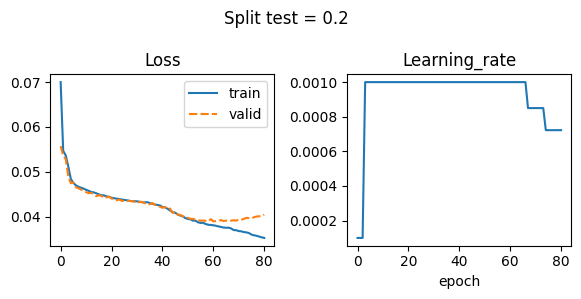

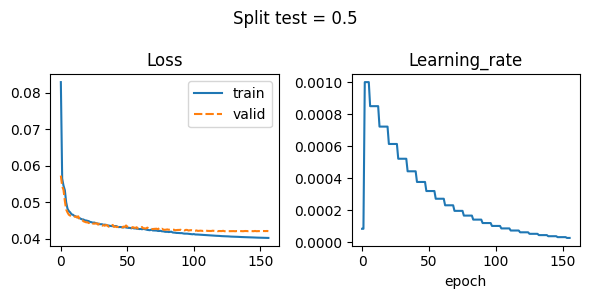

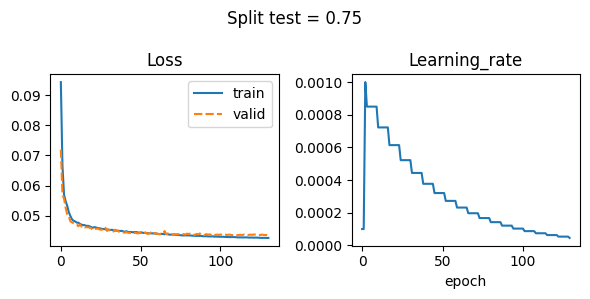

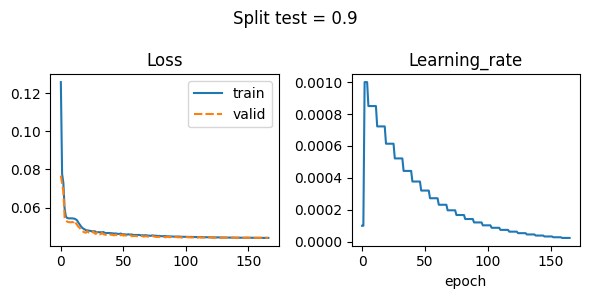

In [66]:
n1 = len(split)
st = 0
ed = 0
for i in range(n1):
    # fig, axs = plt.subplots(figsize=(3,3))
    fig, axs = plt.subplots(ncols=2, figsize=(6,3))
    loss_df = pd.DataFrame()
    lr_df = pd.DataFrame()
    loss_df['train'] = his_t2i[i].history['loss']
    loss_df['valid'] = his_t2i[i].history['val_loss']
    ed += len(loss_df)
    # print(ed)
    lr_df = lr_lis[0][st:ed]
    st = ed+1
    # sns.lineplot(loss_df).set_title("Loss", pad=25)
    sns.lineplot(loss_df,ax=axs[0]).set_title("Loss")
    sns.lineplot(lr_df,ax=axs[1]).set_title("Learning_rate")
    plt.suptitle(f"Split test = {split[i]}")
    plt.xlabel("epoch")
    fig.tight_layout()
    t2i_model_l[i].evaluate(data_split[i][1],  data_split[i][3], verbose=2)

In [132]:
save_file = "text_to_image_" + str(int(split[i]*100))+ ".png"
save_file

'text_to_image_90.png'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
------------------------
Split test = 0.2
------------------------


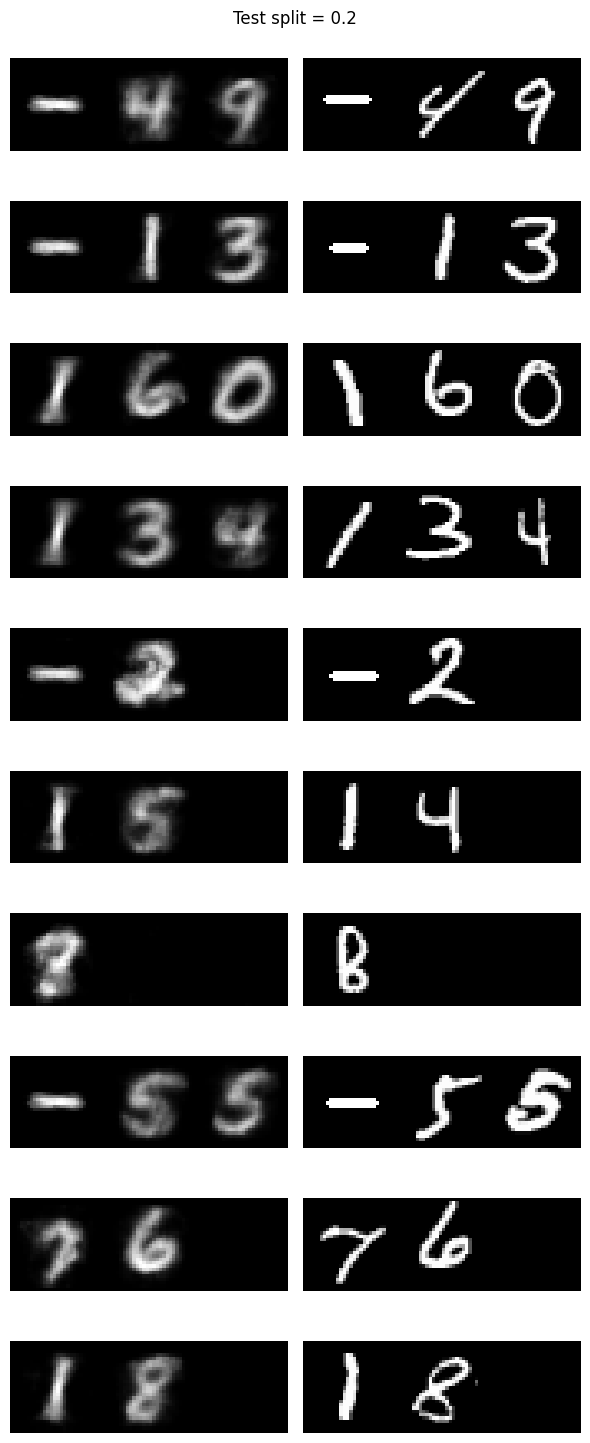

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
------------------------
Split test = 0.5
------------------------


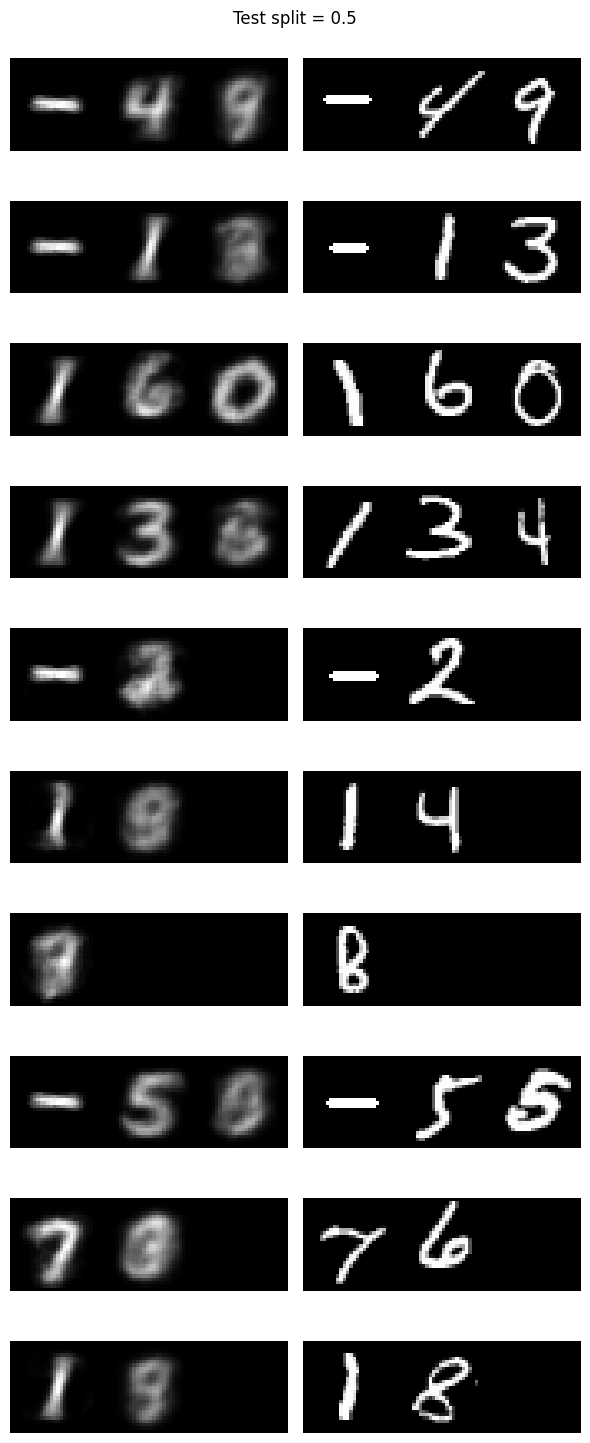

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
------------------------
Split test = 0.75
------------------------


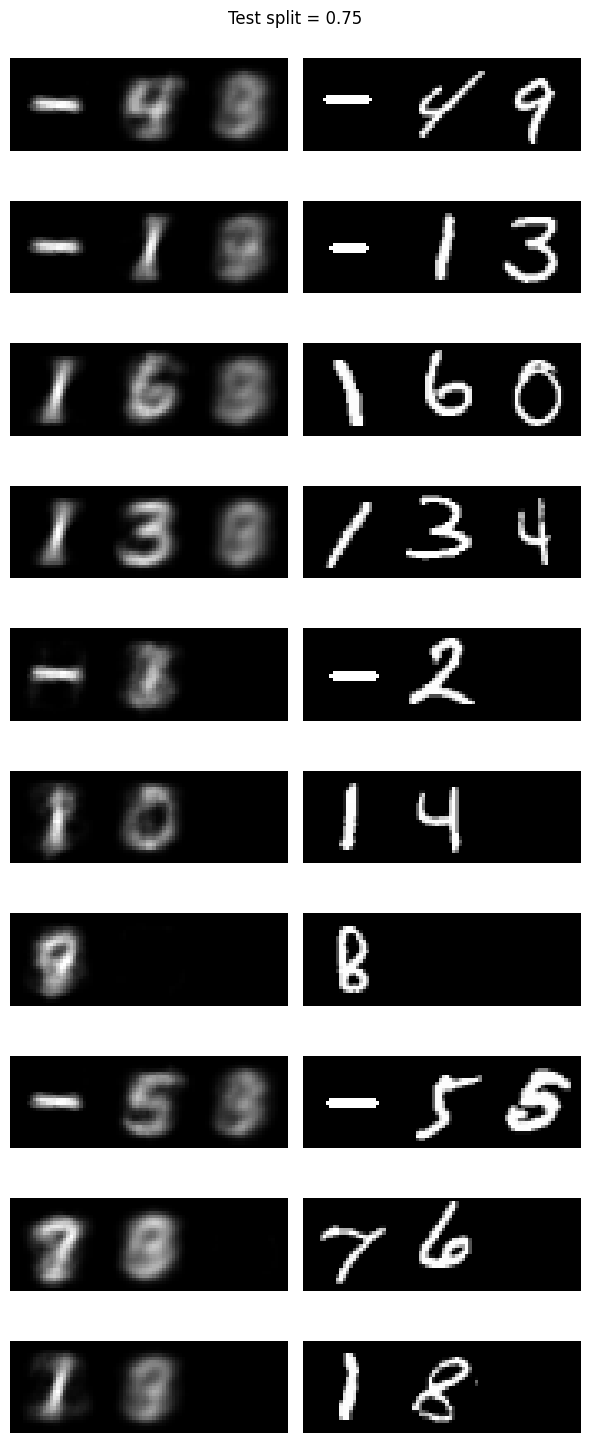

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
------------------------
Split test = 0.9
------------------------


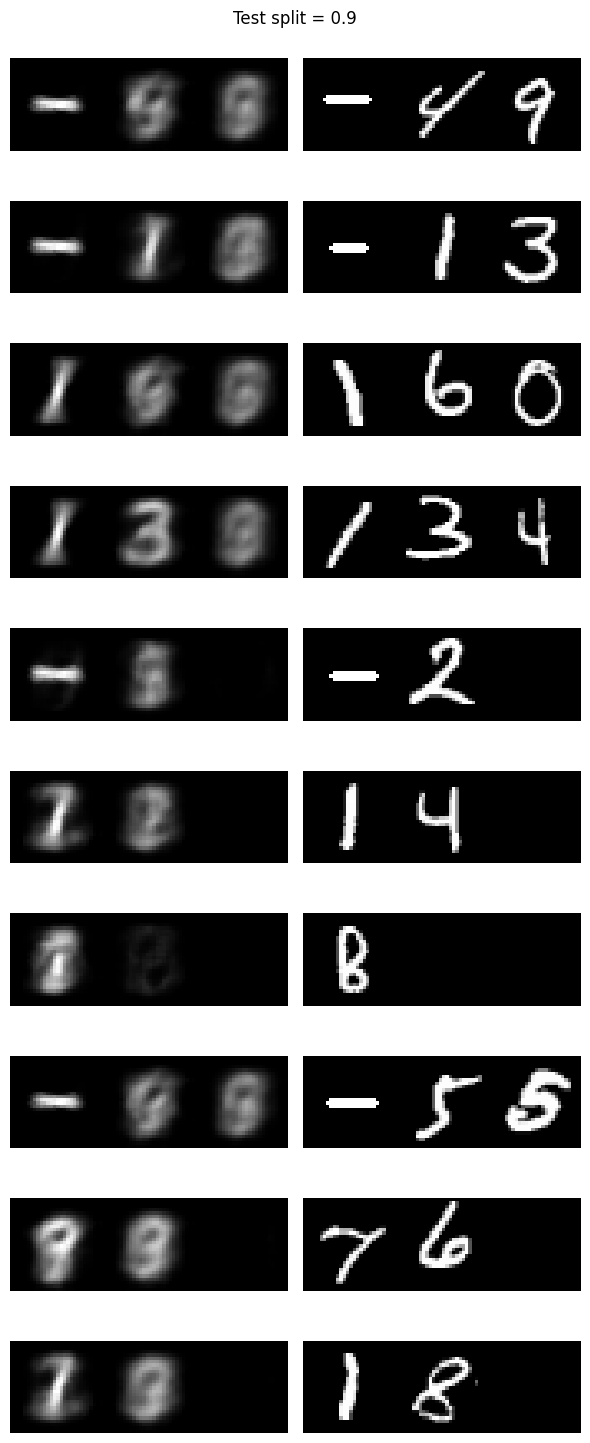

In [135]:
n2 = 10
for i in range(n1):
    pred = t2i_model_l[i].predict(data_split[i][1][:n2])
    print("-"*24)
    print(f"Split test = {split[i]}")
    print("-"*24)
    fig, axes = plt.subplots(n2, 2, figsize=(6, n2*1.5)) #figsize : width, height
    for j in range(n2):
        pred_img = np.hstack(pred[j].reshape(3,28,28))
        # print(f"Q{j+1}: {decode_labels(data_split[i][1][j])}")
        # print(f"Predictions")
        axes[j,0].imshow(pred_img,cmap='gray')
        axes[j,0].axis('off')
        # plt.show()
        # print(f"Correct Answer")
        ans_img = np.hstack(data_split[i][3][j].reshape(3,28,28))
        axes[j,1].imshow(ans_img,cmap='gray')
        axes[j,1].axis('off')
    plt.suptitle(f"Test split = {split[i]}")
    plt.tight_layout()
    save_file = "text_to_image_" + str(int(split[i]*100))+ "_subset.png"
    plt.savefig(save_file, dpi=300, bbox_inches='tight')
    plt.show()
        # print("#"*24)
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


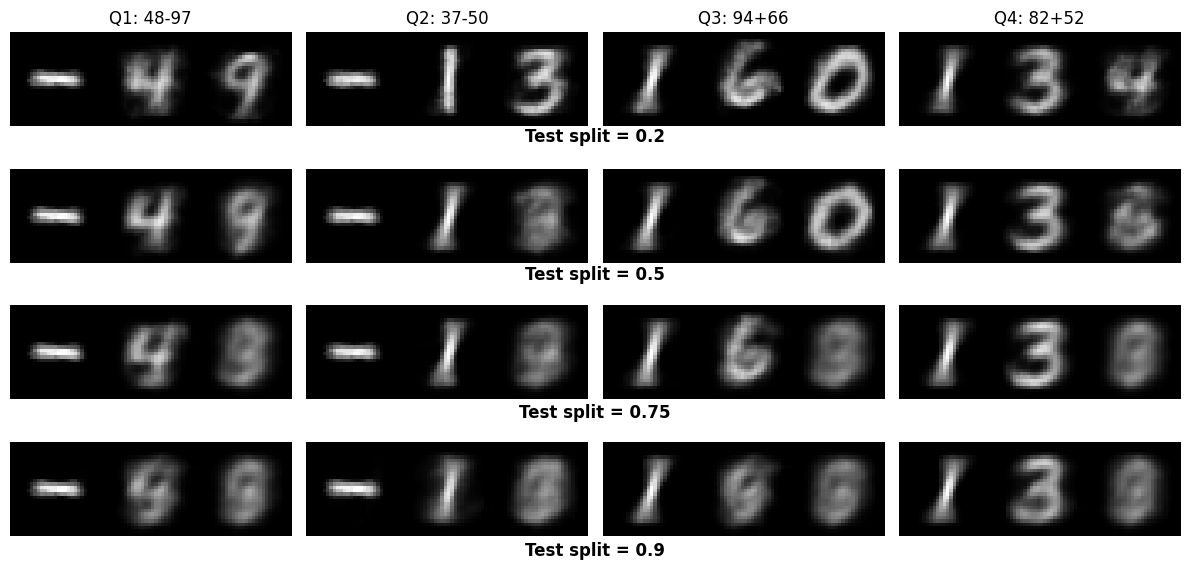

In [169]:
n3 = 4
fig, axes = plt.subplots(n1, n3, figsize=(3*n3, n1*1.5)) #row by col; figsize : width, height 
for i in range(n1): #n1 is number of splits
    pred = t2i_model_l[i].predict(data_split[i][1][:n2])
    # print("-"*24)
    # print(f"Split test = {split[i]}")
    # print("-"*24)
    for j in range(n3):
        pred_img = np.hstack(pred[j].reshape(3,28,28))
        axes[i,j].imshow(pred_img,cmap='gray')
        axes[i,j].axis('off')
        # axes[i,j].set_yticklabels([])
        # axes[i,j].set_xticklabels([])
        # axes[i,j].set_xticks([])
        # axes[i,j].set_yticks([])
        # axes[i,j].set_xlabel(f"Test split = {split[i]}")
        axes[0,j].set_title(f"Q{j+1}: {decode_labels(data_split[i][1][j])}")
            # print(f"Q{j+1}: {decode_labels(data_split[i][1][j])}")
    # plt.suptitle(f"Test split = {split[i]}")
for i, ax_row in enumerate(axes):
    # Create a blank axis spanning the row for text
    fig.text(
        0.5,  # Horizontal position (centered)
        0.74 - i * 0.23,  # Vertical position (adjust per row)
        f"Test split = {split[i]}",  # Label text
        ha='center', va='center', fontsize=12, weight='bold'
    )

plt.tight_layout()
# save_file = "text_to_image_" + str(int(split[i]*100))+ "_subset.png"
# plt.savefig(save_file, dpi=300, bbox_inches='tight')
plt.show()
        # print("#"*24)
    

In [13]:
custom_scheduler2 = CustomLearningRateScheduler(1e-4,reset_lr=1e-3,reset_epoch = [3],patience=7,min_lr=5e-5,cycle=1000,factor=0.9)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
his_t2i2 = []
t2i_model_l2 = []
# split = [0.2] #[0.2,0.5,0.75,0.9]
split = [0.2,0.5,0.75,0.9]
data_split2 = []
for i in range(len(split)):
    train_x, test_x, train_y, test_y = train_test_split(X_text_onehot, y_img, test_size=split[i], random_state=1245)
    data_split2.append([train_x, test_x, train_y, test_y])
    K.clear_session()
    t2i_model2 = build_text2image_model()
    his_t2i2.append(t2i_model2.fit(train_x, train_y,
                                 epochs = 150,
                                 validation_split=0.1,
                                 batch_size = 32,
                                #  callbacks = [early_stopping,reduce_lr],
                                 callbacks = [custom_scheduler2,early_stopping],
                                 verbose = 0))
    t2i_model_l2.append(t2i_model2)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 6272)        │     1,611,904 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 14, 14, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 28, 28, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 28, 28, 1)   │         1,153 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,710,017 (10.34 MB)

 Trainable params: 2,710,017 (10.34 MB)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1733474396.097225 1062158 cuda_dnn.cc:529] Loaded cuDNN version 90300


Resetting learning rate to 1.0e-03 at epoch 3
Reduced learning rate to 9.0e-04 at epoch 69
Reduced learning rate to 8.1e-04 at epoch 76


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 6272)        │     1,611,904 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 14, 14, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 28, 28, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 28, 28, 1)   │         1,153 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,710,017 (10.34 MB)

 Trainable params: 2,710,017 (10.34 MB)

 Non-trainable params: 0 (0.00 B)

Reduced learning rate to 9.0e-05 at epoch 0
Resetting learning rate to 1.0e-03 at epoch 3
Reduced learning rate to 9.0e-04 at epoch 7
Reduced learning rate to 8.1e-04 at epoch 14
Reduced learning rate to 7.3e-04 at epoch 21
Reduced learning rate to 6.6e-04 at epoch 28
Reduced learning rate to 5.9e-04 at epoch 35
Reduced learning rate to 5.3e-04 at epoch 42
Reduced learning rate to 4.8e-04 at epoch 49
Reduced learning rate to 4.3e-04 at epoch 56
Reduced learning rate to 3.9e-04 at epoch 63
Reduced learning rate to 3.5e-04 at epoch 70
Reduced learning rate to 3.1e-04 at epoch 77
Reduced learning rate to 2.8e-04 at epoch 84
Reduced learning rate to 2.5e-04 at epoch 91
Reduced learning rate to 2.3e-04 at epoch 98
Reduced learning rate to 2.1e-04 at epoch 105
Reduced learning rate to 1.9e-04 at epoch 112
Reduced learning rate to 1.7e-04 at epoch 119


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 6272)        │     1,611,904 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 14, 14, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 28, 28, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 28, 28, 1)   │         1,153 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,710,017 (10.34 MB)

 Trainable params: 2,710,017 (10.34 MB)

 Non-trainable params: 0 (0.00 B)

Reduced learning rate to 9.0e-05 at epoch 1
Resetting learning rate to 1.0e-03 at epoch 3
Reduced learning rate to 9.0e-04 at epoch 8
Reduced learning rate to 8.1e-04 at epoch 15
Reduced learning rate to 7.3e-04 at epoch 22
Reduced learning rate to 6.6e-04 at epoch 29
Reduced learning rate to 5.9e-04 at epoch 36
Reduced learning rate to 5.3e-04 at epoch 43
Reduced learning rate to 4.8e-04 at epoch 50
Reduced learning rate to 4.3e-04 at epoch 57
Reduced learning rate to 3.9e-04 at epoch 64
Reduced learning rate to 3.5e-04 at epoch 71
Reduced learning rate to 3.1e-04 at epoch 78
Reduced learning rate to 2.8e-04 at epoch 85
Reduced learning rate to 2.5e-04 at epoch 92


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 6272)        │     1,611,904 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 7, 7, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 14, 14, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 28, 28, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 28, 28, 1)   │         1,153 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,710,017 (10.34 MB)

 Trainable params: 2,710,017 (10.34 MB)

 Non-trainable params: 0 (0.00 B)

Resetting learning rate to 1.0e-03 at epoch 3
Reduced learning rate to 9.0e-04 at epoch 6
Reduced learning rate to 8.1e-04 at epoch 13
Reduced learning rate to 7.3e-04 at epoch 20
Reduced learning rate to 6.6e-04 at epoch 27
Reduced learning rate to 5.9e-04 at epoch 34
Reduced learning rate to 5.3e-04 at epoch 41
Reduced learning rate to 4.8e-04 at epoch 48
Reduced learning rate to 4.3e-04 at epoch 55
Reduced learning rate to 3.9e-04 at epoch 62
Reduced learning rate to 3.5e-04 at epoch 69
Reduced learning rate to 3.1e-04 at epoch 76
Reduced learning rate to 2.8e-04 at epoch 83
Reduced learning rate to 2.5e-04 at epoch 90
Reduced learning rate to 2.3e-04 at epoch 97
Reduced learning rate to 2.1e-04 at epoch 104


83
125/125 - 1s - 6ms/step - loss: 0.0398
124
313/313 - 3s - 9ms/step - loss: 0.0424
92
469/469 - 4s - 9ms/step - loss: 0.0450
106
563/563 - 5s - 8ms/step - loss: 0.0461


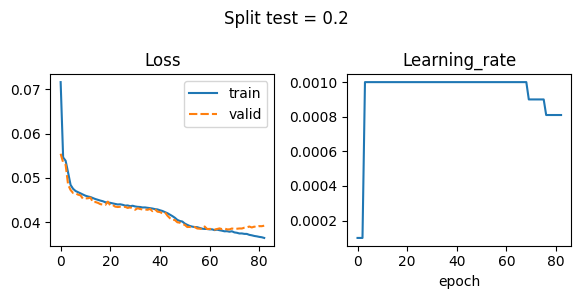

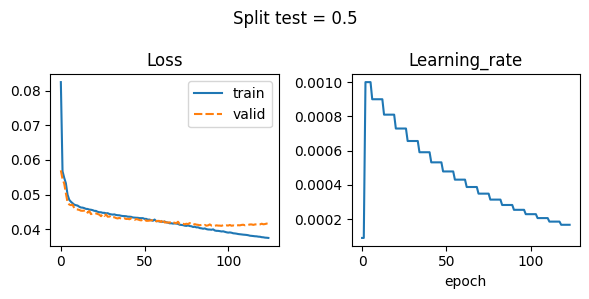

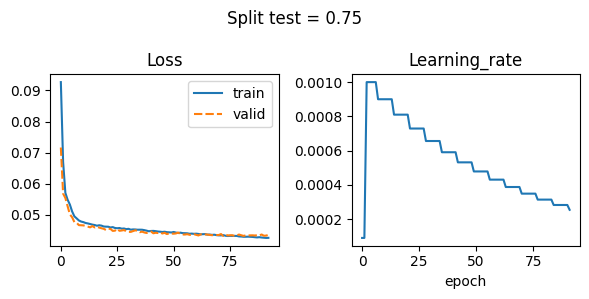

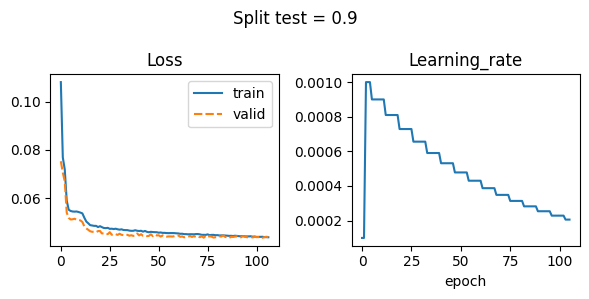

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
------------------------
Split test = 0.2
------------------------
Q0: 48-97
Predictions


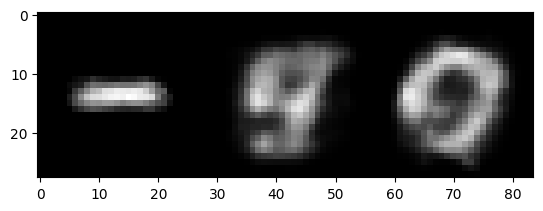

Correct Answer


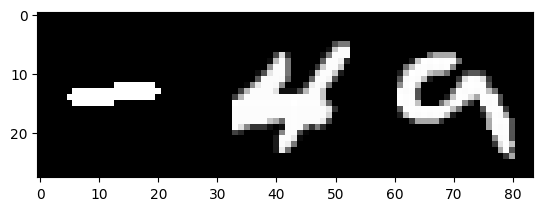

########################
Q1: 37-50
Predictions


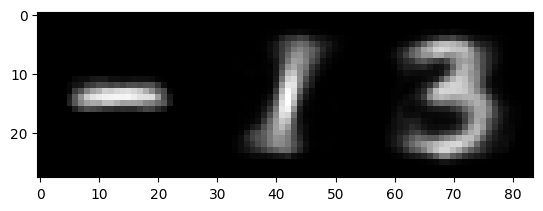

Correct Answer


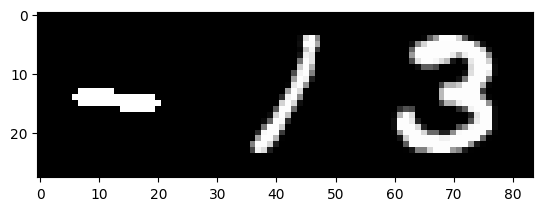

########################
Q2: 94+66
Predictions


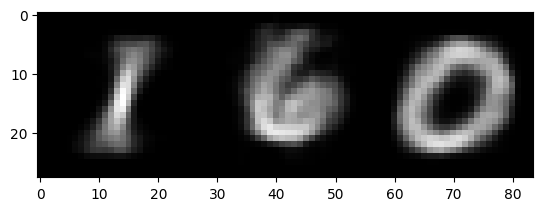

Correct Answer


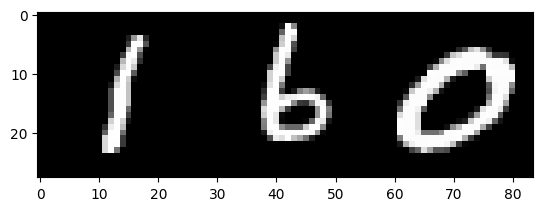

########################
Q3: 82+52
Predictions


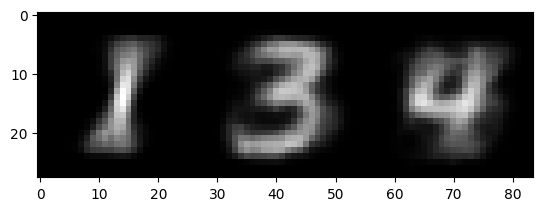

Correct Answer


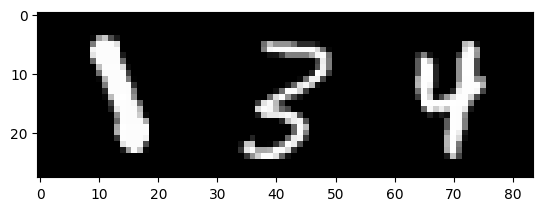

########################
Q4: 93-95
Predictions


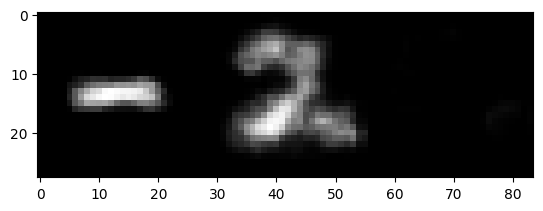

Correct Answer


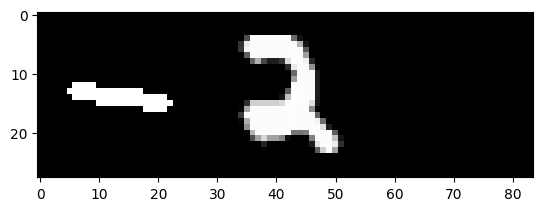

########################
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
------------------------
Split test = 0.5
------------------------
Q0: 48-97
Predictions


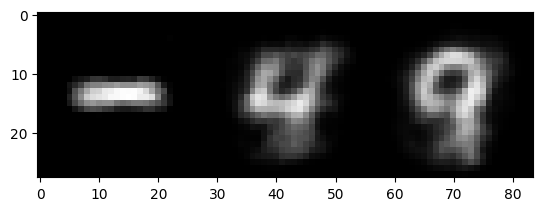

Correct Answer


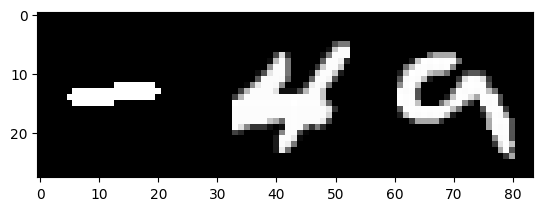

########################
Q1: 37-50
Predictions


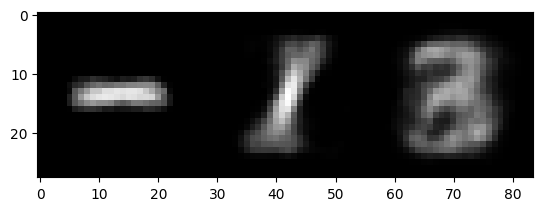

Correct Answer


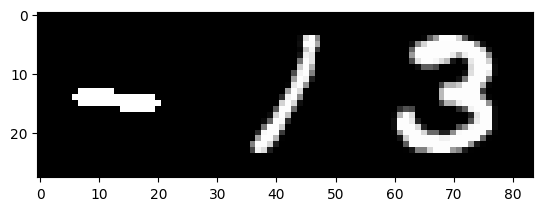

########################
Q2: 94+66
Predictions


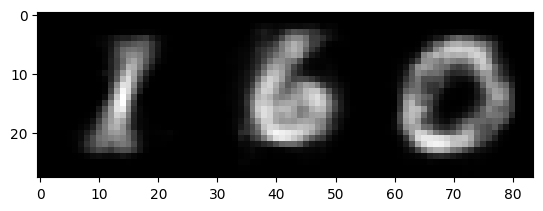

Correct Answer


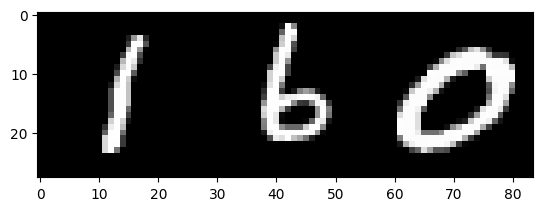

########################
Q3: 82+52
Predictions


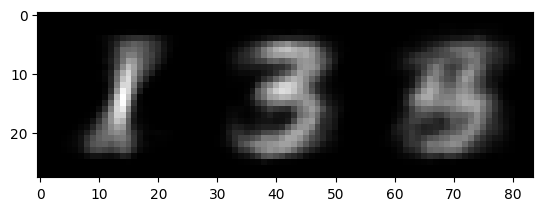

Correct Answer


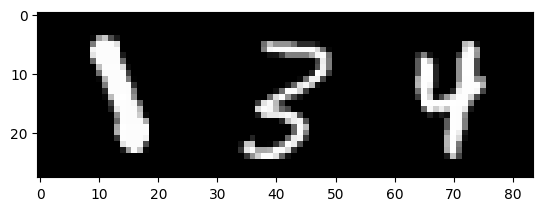

########################
Q4: 93-95
Predictions


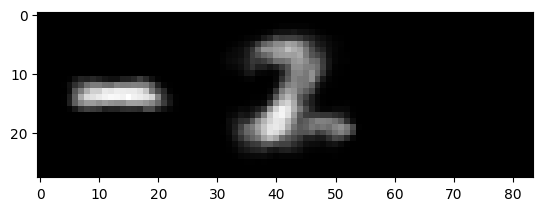

Correct Answer


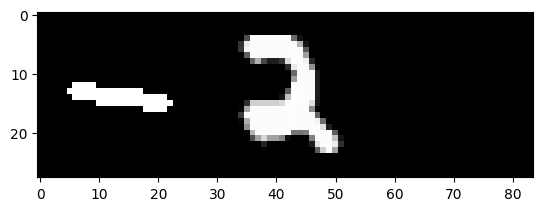

########################
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
------------------------
Split test = 0.75
------------------------
Q0: 48-97
Predictions


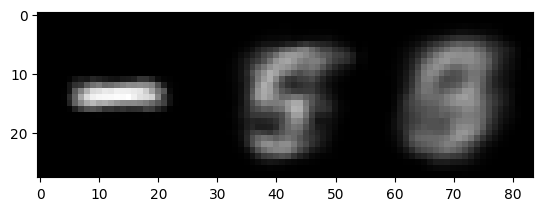

Correct Answer


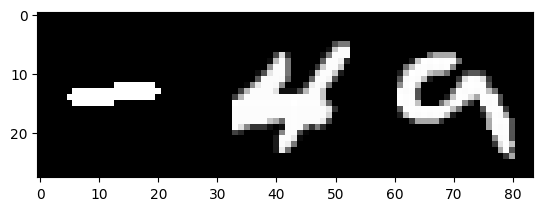

########################
Q1: 37-50
Predictions


KeyboardInterrupt: 

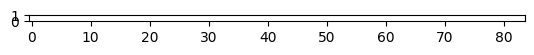

In [18]:
n1 = len(split)
st = 0
ed = 0
for i in range(n1):
    # fig, axs = plt.subplots(figsize=(3,3))
    fig, axs = plt.subplots(ncols=2, figsize=(6,3))
    loss_df = pd.DataFrame()
    lr_df = pd.DataFrame()
    loss_df['train'] = his_t2i2[i].history['loss']
    loss_df['valid'] = his_t2i2[i].history['val_loss']
    ed += len(loss_df)
    print(ed-st)
    lr_df = custom_scheduler2.lr_history[st:ed]
    st = ed+1
    # sns.lineplot(loss_df).set_title("Loss", pad=25)
    sns.lineplot(loss_df,ax=axs[0]).set_title("Loss")
    sns.lineplot(lr_df,ax=axs[1]).set_title("Learning_rate")
    plt.suptitle(f"Split test = {split[i]}")
    plt.xlabel("epoch")
    fig.tight_layout()
    t2i_model_l2[i].evaluate(data_split2[i][1],  data_split2[i][3], verbose=2)
plt.show()
n2 = 5
for i in range(n1):
    pred = t2i_model_l2[i].predict(data_split2[i][1][:n2])
    print("-"*24)
    print(f"Split test = {split[i]}")
    print("-"*24)
    for j in range(n2):
        pred_img = np.hstack(pred[j].reshape(3,28,28))
        print(f"Q{j}: {decode_labels(data_split2[i][1][j])}")
        print(f"Predictions")
        plt.imshow(pred_img,cmap='gray')
        plt.show()
        print(f"Correct Answer")
        ans_img = np.hstack(data_split2[i][3][j].reshape(3,28,28))
        plt.imshow(ans_img,cmap='gray')
        plt.show()
        print("#"*24)

In [ ]:
def tt2i_decoder():
    input = Input(shape=(3, len(unique_characters)))
    x = LSTM(256,return_sequences=True)(input)
    x = TimeDistributed(Dense(7 * 7 * 64))(input)
    x = Reshape((max_answer_length, 7, 7, 64))(x)  # Shape: (max_answer_length, 4, 4, 64)
    
    # Convolutional Upsampling
    x = TimeDistributed(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))(x)  
    x = TimeDistributed(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))(x)  
    
    # Final Upsampling to 28x28
    output = TimeDistributed(Conv2D(1, (3, 3), padding='same', activation='sigmoid'))(x)  
    # Model Compilation
    model = tf.keras.Model(input, output)
    model.compile(optimizer='adam', loss='mse')  # Use MSE or an alternative loss
    model.summary()
    return model
tt2i_decoder()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3, 13)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 3, 3136)        │        43,904 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 3, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 3, 14, 14, 128) │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 3, 28, 28, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 3, 28, 28, 1)   │         1,153 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,497 (1.02 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

<Functional name=functional_1, built=True>

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3, 13)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 3136)        │        43,904 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 14, 14, 128) │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 28, 28, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 28, 28, 1)   │         1,153 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,497 (1.02 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1382 - val_loss: 0.0411 - learning_rate: 0.0010
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0429 - val_loss: 0.0389 - learning_rate: 0.0010
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0412 - val_loss: 0.0377 - learning_rate: 0.0010
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0402 - val_loss: 0.0364 - learning_rate: 0.0010
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0387 - val_loss: 0.0360 - learning_rate: 0.0010
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0385 - val_loss: 0.0359 - learning_rate: 0.0010
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0386 - val_loss: 0.0358 - learning_rate: 0.0010
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0387 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0390 - val_loss: 0.0356 - learning_rate: 0.0010
Epoch 10/10
57/57 ━━━━━━━━━

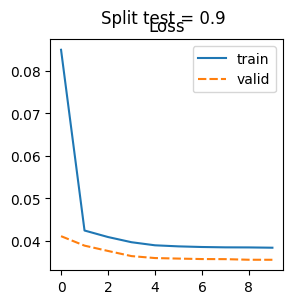

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
Q0: -49


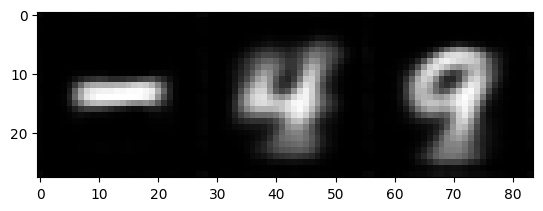

Q1: -13


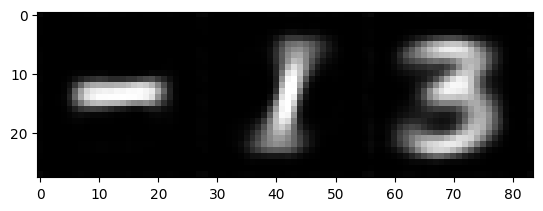

In [49]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)

his_t2idec = []
t2idec_model_l = []
split = [0.9]
data_split = []
for i in range(len(split)):
    train_x, test_x, train_y, test_y = train_test_split(y_text_onehot, y_img, test_size=split[i], random_state=1245)
    data_split.append([train_x, test_x, train_y, test_y])
    K.clear_session()
    t2idec_model = tt2i_decoder()
    his_t2idec.append(t2idec_model.fit(train_x, train_y,
                                 epochs = 10,
                                 validation_split=0.1,
                                 batch_size = 32,
                                 verbose = 1,
                                 callbacks = [early_stopping,reduce_lr]))
    t2idec_model_l.append(t2idec_model)
n2 = 2
for i in range(len(split)):
    fig, axs = plt.subplots(figsize=(3,3))
    loss_df = pd.DataFrame()
    loss_df['train'] = his_t2idec[i].history['loss']
    loss_df['valid'] = his_t2idec[i].history['val_loss']
    sns.lineplot(loss_df).set_title("Loss")
    plt.suptitle(f"Split test = {split[i]}")
    plt.show()
    pred = t2idec_model_l[i].predict(data_split[i][1][:n2])
    for j in range(n2):
        pred_img = np.hstack(pred[j].reshape(3,28,28))
        print(f"Q{j}: {decode_labels(data_split[i][1][j])}")
        plt.imshow(pred_img,cmap='gray')
        plt.show()

In [57]:
def tt2i_encoder():
    text2text = tf.keras.Sequential()
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))
    text2text.add(RepeatVector(max_answer_length))
    text2text.add(LSTM(256, return_sequences=True))
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
    text2text.summary()
    return text2text

def tt2i_decoder():
    input = Input(shape=(3, len(unique_characters)))
    # x = LSTM(256,return_sequences=True)(input)
    x = TimeDistributed(Dense(7 * 7 * 64))(input)
    # print(x.shape)
    x = Reshape((-1, 7, 7, 64))(x)  
    x = TimeDistributed(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))(x) 
    x = TimeDistributed(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))(x) 
    output = TimeDistributed(Conv2D(1, (3, 3), padding='same', activation='sigmoid'))(x) 
    # Model Compilation
    model = tf.keras.Model(input, output)
    model.summary()
    return model

def build_t2i_model():
    encoder = tt2i_encoder()
    decoder = tt2i_decoder()

    # We connect encoder and decoder into a single model
    model = tf.keras.Sequential([encoder, decoder])
    # Binary crossentropy loss - pairwise comparison between input and output pixels
    model.compile(optimizer='adam', loss='mse')
    return model

build_t2i_model()

/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3, 13)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 3, 3136)        │        43,904 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 3, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 3, 14, 14, 128) │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 3, 28, 28, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 3, 28, 28, 1)   │         1,153 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,497 (1.02 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

<Sequential name=sequential_1, built=True>

In [58]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

his_t2i2 = []
t2i2_model_l = []
split = [0.2]
data_split = []
for i in range(len(split)):
    train_x, test_x, train_y, test_y = train_test_split(X_text_onehot, y_img, test_size=split[i], random_state=1245)
    data_split.append([train_x, test_x, train_y, test_y])
    K.clear_session()
    t2i2_model = build_t2i_model()
    his_t2i2.append(t2idec_model.fit(train_x, train_y,
                                 epochs = 10,
                                 validation_split=0.1,
                                 batch_size = 32,
                                 verbose = 1,
                                 callbacks = [early_stopping]))
    t2i2_model_l.append(t2idec_model)
n2 = 2
for i in range(len(split)):
    fig, axs = plt.subplots(figsize=(3,3))
    loss_df = pd.DataFrame()
    loss_df['train'] = his_t2i2[i].history['loss']
    loss_df['valid'] = his_t2i2[i].history['val_loss']
    sns.lineplot(loss_df).set_title("Loss")
    plt.suptitle(f"Split test = {split[i]}")
    plt.show()
    pred = t2i2_model_l[i].predict(data_split[i][1][:n2])
    for j in range(n2):
        pred_img = np.hstack(pred[j].reshape(3,28,28))
        print(f"Q{j}: {decode_labels(data_split[i][1][j])}")
        plt.imshow(pred_img,cmap='gray')
        plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3, 13)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 3136)        │        43,904 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 14, 14, 128) │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 28, 28, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 3, 28, 28, 1)   │         1,153 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,497 (1.02 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2024-11-25 12:14:00.156325: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at xla_ops.cc:577 : INVALID_ARGUMENT: XLA compilation requires a fixed tensor list size. Set the max number of elements. This could also happen if you're using a TensorArray in a while loop that does not have its maximum_iteration set, you can fix this by setting maximum_iteration to a suitable value.

Stack trace for op definition: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/tornado/platform/asy

InvalidArgumentError: Graph execution error:

Detected at node loop_body/strided_slice_1/pfor/while/Placeholder_0/accumulator defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_3523276/3035865655.py", line 12, in <module>

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 70, in train_step

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/tensorflow/core/function/capture/capture_container.py", line 154, in capture_by_value

XLA compilation requires a fixed tensor list size. Set the max number of elements. This could also happen if you're using a TensorArray in a while loop that does not have its maximum_iteration set, you can fix this by setting maximum_iteration to a suitable value.

Stack trace for op definition: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/asyncio/base_events.py", line 641, in run_forever
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/asyncio/events.py", line 88, in _run
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
File "/tmp/ipykernel_3523276/3035865655.py", line 12, in <module>
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 70, in train_step
File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/tensorflow/core/function/capture/capture_container.py", line 154, in capture_by_value

	 [[{{node loop_body/strided_slice_1/pfor/while/Placeholder_0/accumulator}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_75605[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_75664]

In [54]:
def build_t2i2_model():
    input = Input(shape=(None, len(unique_characters)))
    x = LSTM(256)(input)
    x = RepeatVector(max_answer_length)(x)
    x = LSTM(256,return_sequences=True)(x)
    encode1 = TimeDistributed(Dense(len(unique_characters),activation='softmax'))(x)
    
    y = LSTM(256,return_sequences=True)(encode1)
    y = TimeDistributed(Dense(7 * 7 * 64))(y)
    print(y.shape)
    
    y = Reshape((max_answer_length, 7, 7, 64))(y)  # Shape: (max_answer_length, 4, 4, 64)
    
    # Convolutional Upsampling
    y = TimeDistributed(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))(y)  # 4x4 -> 8x8
    y = TimeDistributed(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))(y)   # 8x8 -> 16x16
    
    # Final Upsampling to 28x28
    output = TimeDistributed(Conv2D(1, (3, 3), padding='same', activation='sigmoid'))(y)  # 16x16 -> 28x28

    # # Model Compilation
    model = tf.keras.Model(input, output)
    model.compile(optimizer='adam', loss='mse')  # Use MSE or an alternative loss
    model.summary()
    return model
build_t2i2_model()


(None, 3, 3136)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, None, 13)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 3, 256)         │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 3, 3136)        │       805,952 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 3, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 3, 14, 14, 128) │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 3, 28, 28, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 3, 28, 28, 1)   │         1,153 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,110,158 (8.05 MB)

 Trainable params: 2,110,158 (8.05 MB)

 Non-trainable params: 0 (0.00 B)

<Functional name=functional_2, built=True>

In [49]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

his_t2i2 = []
t2i2_model_l = []
split = [0.2]
data_split = []
for i in range(len(split)):
    train_x, test_x, train_y, test_y = train_test_split(X_text_onehot, y_img, test_size=split[i], random_state=1245)
    data_split.append([train_x, test_x, train_y, test_y])
    K.clear_session()
    t2i2_model = build_t2i2_model()
    his_t2i2.append(t2idec_model.fit(train_x, train_y,
                                 epochs = 10,
                                 validation_split=0.1,
                                 batch_size = 32,
                                 verbose = 1,
                                 callbacks = [early_stopping]))
    t2i2_model_l.append(t2idec_model)
n2 = 2
for i in range(len(split)):
    fig, axs = plt.subplots(figsize=(3,3))
    loss_df = pd.DataFrame()
    loss_df['train'] = his_t2i2[i].history['loss']
    loss_df['valid'] = his_t2i2[i].history['val_loss']
    sns.lineplot(loss_df).set_title("Loss")
    plt.suptitle(f"Split test = {split[i]}")
    plt.show()
    pred = t2i2_model_l[i].predict(data_split[i][1][:n2])
    for j in range(n2):
        pred_img = np.hstack(pred[j].reshape(3,28,28))
        print(f"Q{j}: {decode_labels(data_split[i][1][j])}")
        plt.imshow(pred_img,cmap='gray')
        plt.show()

(None, 3, 3136)


ValueError: Kernel shape must have the same length as input, but received kernel of shape (3, 3, 128, 1) and input of shape (None, 128).

In [47]:
501760/(3*3136)

53.333333333333336